In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold

In [244]:
df = pd.read_csv('../dataset/bank_marketing.csv')

In [245]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [246]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [247]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [248]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

filled_df = df.copy()

filled_df[categorical] = df[categorical].fillna('NA')

filled_df = filled_df.fillna(0)

filled_df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [249]:
filled_df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [250]:
train_full_df, test_df = train_test_split(filled_df, random_state=1, test_size=0.2)

train_df, val_df = train_test_split(train_full_df, random_state=1, test_size=0.25)

y_train = train_df['converted']
y_val = val_df['converted']
y_test = test_df['converted']

del train_df['converted']
del val_df['converted']
del test_df['converted']

len(train_df), len(val_df), len(test_df)

(876, 293, 293)

In [251]:
len(y_train), len(y_val), len(y_test)

(876, 293, 293)

In [252]:
for col in numerical:

    print(col, roc_auc_score(y_train, train_df[col]))

# number_of_courses_viewed is the highest

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


In [253]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(pd.get_dummies(train_df), y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [254]:
y_pred = model.predict_proba(pd.get_dummies(val_df))[:, 1]

In [255]:
round(roc_auc_score(y_val, y_pred), 3)

0.817

In [262]:
threshold = np.arange(0, 1, 0.01)

precision_scores = []

recall_scores = []

f1_scores = []

for t in threshold:

    y_scores = (y_pred >= t).astype(int)

    precision = precision_score(y_val, y_scores, zero_division=0)

    recall = recall_score(y_val, y_scores, zero_division=0)

    f1 = f1_score(y_val, y_scores)

    precision_scores.append(precision)

    recall_scores.append(recall)

    f1_scores.append(f1)


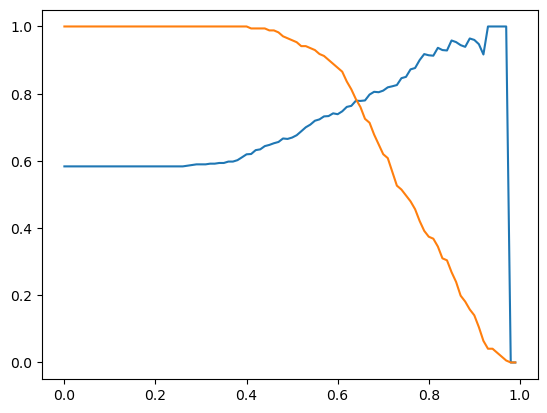

In [263]:
plt.plot(threshold, precision_scores)
plt.plot(threshold, recall_scores)

In [264]:
threshold_f1_dict = dict(zip(threshold, f1_scores))

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = threshold[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1-score: {max_f1_score:.4f}")
print(f"Achieved at threshold: {max_f1_threshold:.2f}")

Maximum F1-score: 0.8125
Achieved at threshold: 0.57


In [269]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(train_full_df):
    
    X_train_fold = train_full_df.iloc[train_idx]
    X_val_fold = train_full_df.iloc[val_idx]
    
    X_train_processed = pd.get_dummies(X_train_fold[numerical + categorical])
    X_val_processed = pd.get_dummies(X_val_fold[numerical + categorical])

    y_train_fold = X_train_fold['converted']
    y_val_fold = X_val_fold['converted']


    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train_processed, y_train_fold)

    y_pred = model.predict_proba(X_val_processed)[:, 1]

    score = roc_auc_score(y_val_fold, y_pred)

    scores.append(score)

In [270]:
np.std(scores)

0.03580711942905165

In [271]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

c_values = [0.000001, 0.001, 1]

for c in c_values:

    scores = []

    for train_idx, val_idx in kfold.split(train_full_df):
        
        X_train_fold = train_full_df.iloc[train_idx]
        X_val_fold = train_full_df.iloc[val_idx]
        
        X_train_processed = pd.get_dummies(X_train_fold[numerical + categorical])
        X_val_processed = pd.get_dummies(X_val_fold[numerical + categorical])

        y_train_fold = X_train_fold['converted']
        y_val_fold = X_val_fold['converted']


        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)

        model.fit(X_train_processed, y_train_fold)

        y_pred = model.predict_proba(X_val_processed)[:, 1]

        score = roc_auc_score(y_val_fold, y_pred)

        scores.append(score)
    
    print(c, np.mean(scores))

1e-06 0.560207852870275
0.001 0.8668780317675395
1 0.8221089148573075
